In [1]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

import cv2

def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [7]:
label_file="/cxldata/dlcourse/mask_rcnn_model_data/object_detection_classes_coco.txt"
LABELS = open(label_file).read().strip().split("\n")

COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
dtype="uint8")

LABELS[:5]

['person', 'bicycle', 'car', 'motorcycle', 'airplane']

In [13]:
weights="/cxldata/dlcourse/mask_rcnn_model_data/mask_rcnn_frozen_inference_graph.pb"
config = "/cxldata/dlcourse/mask_rcnn_model_data/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"

net = cv2.dnn.readNetFromTensorflow(weights, config)

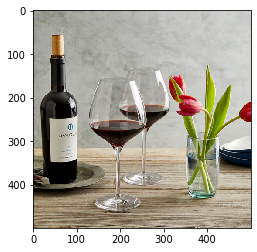

In [17]:
img = cv2.imread('/cxldata/dlcourse/mask_rcnn_model_data/dining_table.jpg')

plt.imshow(fixColor(img))

blob = cv2.dnn.blobFromImage(img, swapRB=True, crop=False)

net.setInput(blob)

In [21]:
(boxes, masks_polygons) = net.forward(["detection_out_final",
    "detection_masks"])

print(boxes.shape)

print(masks_polygons.shape)

(1, 1, 7, 7)
(100, 90, 15, 15)


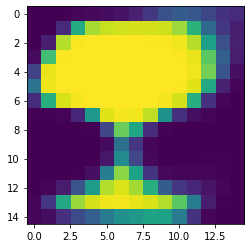

Shape of individual mask (15, 15)
Mask after resize (328, 148)
Mask after threshold (328, 148)
ROI Shape (12764, 3)
wine glass [156, 21, 112]


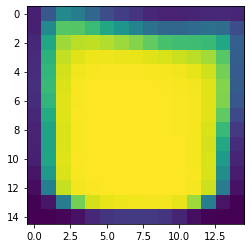

Shape of individual mask (15, 15)
Mask after resize (154, 81)
Mask after threshold (154, 81)
ROI Shape (6072, 3)
vase [166, 56, 167]


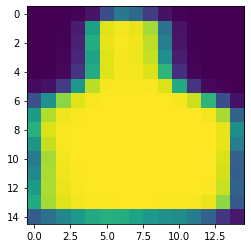

Shape of individual mask (15, 15)
Mask after resize (344, 83)
Mask after threshold (344, 83)
ROI Shape (13497, 3)
bottle [209, 226, 77]


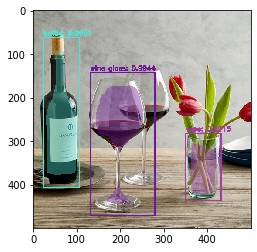

In [25]:
threshold = 0.9

for i in range(0, boxes.shape[2]): #For each detection
    classID = int(boxes[0, 0, i, 1]) #Class ID
    confidence = boxes[0, 0, i, 2] #Confidence scores
    if confidence > threshold:
        (H, W) = img.shape[:2]
        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H]) #Bounding box
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY

        # extract the pixel-wise segmentation for the object, and visualize the mask       
        mask = masks_polygons[i, classID]
        plt.imshow(mask)
        plt.show()
        print ("Shape of individual mask", mask.shape)

        # resize the mask such that it's the same dimensions of
        # the bounding box, and interpolation gives individual pixel positions
        mask = cv2.resize(mask, (boxW, boxH), interpolation=cv2.INTER_CUBIC)

        print ("Mask after resize", mask.shape)
        # then finally threshold to create a *binary* mask
        mask = (mask > threshold)
        print ("Mask after threshold", mask.shape)
        # extract the ROI of the image but *only* extracted the
        # masked region of the ROI
        roi = img[startY:endY, startX:endX][mask]
        print ("ROI Shape", roi.shape)

        # grab the color used to visualize this particular class,
        # then create a transparent overlay by blending the color
        # with the ROI
        color = COLORS[classID]
        blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")

        # Change the colors in the original to blended color
        img[startY:endY, startX:endX][mask] = blended

        color = COLORS[classID]
        color = [int(c) for c in color]
        print (LABELS[classID], color)
        cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)
        text = "{}: {:.4f}".format(LABELS[classID], confidence)
        cv2.putText(img, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.imshow(fixColor(img))